In [1]:
#import DESTiler

#tiler=DESTiler.DESTiler("DES_DR1_TILE_INFO.csv")


This notebook allows you to make the stamps and corresponding masks used to train our torch model. Right now this is set up to work with ACT data but it should be fairly straightforward to modify it to work with Websky. Additionally this was written for DR5. We should probably update this for DR6. Finally for performance reasons we may want to update this to a script.

In [1]:
def inv_var(data, variances):
    ave = 0
    var = 0
    for i in range(len(data)):
        ave += data[i]/variances[i]
        var += 1/variances[i]
    return ave/var, 1/var

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
import os, sys
import pickle as pk
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.coordinates import SkyCoord
import yaml
from pixell import enmap,utils, reproject, enplot
from scipy import interpolate
import random
from astropy.nddata import block_reduce, block_replicate

import pickle as pk

from PIL import Image

from astLib import astWCS, astImages
from scipy import ndimage

from pixell.enmap import sky2pix

from astropy.wcs import WCS

from astroquery.skyview import SkyView

from stamping_utils import autotiler, getTileCoordsDict, make_jpg, normalize_map, make_mask, make_mask_wise, _make_jpg

%load_ext autoreload
%autoreload 2

%matplotlib inline



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#Matt Hilton wrote a program called autotiler which breaks up a map into tiles of a given width, height, and overlap
#and within a given mask.

tileDefinitions = {"mask": "./DR5_cluster-search-area-mask_v1.0.fits", #TODO: this is the DR5 mask, I'm not sure how diferent it is from DR6
                  "targetTileWidthDeg": 1.0, 
                  "targetTileHeightDeg": 1.0}
hdu = fits.open('./DR5_cluster-search-area-mask_v1.0.fits')
mask = hdu[1].data
wcs_mask = astWCS.WCS(hdu[1].header,mode="pyfits")
w = WCS(hdu[1].header)
tileOverlapDeg = 0.5

In [4]:
tilelist = autotiler(mask,wcs_mask,tileDefinitions["targetTileWidthDeg"],tileDefinitions["targetTileHeightDeg"])

In [5]:
clipCoordsDict=getTileCoordsDict(tilelist,wcs_mask,tileOverlapDeg)

In [6]:
act_catalog = fits.open('/mnt/welch/USERS/jorlo/DR6_cluster-catalog_v0.2.fits')

ras, decs = np.array(act_catalog[1].data['RADeg']), np.array(act_catalog[1].data['decDeg'])



In [22]:

for key in clipCoordsDict.keys():
    minX, maxX, minY, maxY=clipCoordsDict[key]['clippedSection']
    ra_min, dec_max = wcs_mask.pix2wcs(maxX, maxY)
    ra_max, dec_min = wcs_mask.pix2wcs(minX, minY)
    #print(ra_max, ra_min)
    in_image = np.where((ra_min < ras) & (ras < ra_max) & (dec_min < decs) & (decs < dec_max))[0]
    if len(in_image) == 0:
        print('no clusters')
        continue

    if ra_max < ra_min:
        ra_min -= 360
    
    box = np.array([[dec_min, ra_min],[dec_max, ra_max]]) * utils.degree
    freqs = ["090", "150", "220"]
    #Make jpg of box
    jpg, cur_wcs = _make_jpg('/mnt/welch/USERS/jorlo/maps/20240323_simple/act_planck_*_f*_daynight_map_srcfree.fits', box, freqs)
    if type(jpg) == int: continue

    #np.savez_compressed("/project/r/rbond/jorlo/datasets/ACT_tiles/small_freq_tiles/{}".format(key), jpg)
    np.savez_compressed("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles_PSD/small_freq_tiles/{}".format(key), jpg)
    mask = make_mask(jpg, act_catalog, [[ra_min, ra_max], [dec_min, dec_max]], cur_wcs, size = 4.8)
    #print(mask.shape)
    #np.savez_compressed("/project/r/rbond/jorlo/datasets/ACT_tiles/small_masks/{}_mask".format(key), mask)
    np.savez_compressed("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles_PSD/small_masks/{}_mask".format(key), mask)

(3, 244, 356)
(3, 244, 356)
no clusters
(3, 244, 356)
(3, 244, 357)
(3, 244, 356)
no clusters
(3, 244, 356)
(3, 244, 356)
(3, 244, 357)
(3, 244, 356)
(3, 244, 356)
no clusters
(3, 244, 356)
(3, 244, 357)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
no clusters
no clusters
no clusters
(3, 244, 356)
(3, 244, 356)
(3, 244, 357)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 357)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 357)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 357)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 357)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 357)
(3, 244, 356)
(3, 244, 356)
no clusters
no clusters
(3, 244, 357)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
no clusters
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 357)
no clusters
(3, 244, 356)
(3, 244, 356)
(3, 244, 356)
(3, 244, 357)
(3, 244, 356)
(3, 244, 356)
(3, 244, 356

In [34]:
key = '1_0_0'

minX, maxX, minY, maxY=clipCoordsDict[key]['clippedSection']
ra_min, dec_max = wcs_mask.pix2wcs(maxX, maxY)
ra_max, dec_min = wcs_mask.pix2wcs(minX, minY)
#print(ra_max, ra_min)
in_image = np.where((ra_min < ras) & (ras < ra_max) & (dec_min < decs) & (decs < dec_max))[0]
if len(in_image) == 0:
    print('no clusters')

if ra_max < ra_min:
    ra_min -= 360

box = np.array([[dec_min, ra_min],[dec_max, ra_max]]) * utils.degree
#c1 = SkyCoord(ra_min, dec_min, frame='icrs', unit='deg')
#c2 = SkyCoord(ra_max, dec_max, frame='icrs', unit='deg')

#print(dec_min, dec_max)
#print(c1.ra.hms, c2.ra.hms)
#print(box)
#Make jpg of box
jpg, cur_wcs = make_jpg('/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/', box)
#plt.imshow(jpg[...,0])
#plt.show()
#plt.close()
#im = Image.fromarray(jpg, 'RGB')
#im.save("/project/r/rbond/jorlo/datasets/ACT_tiles/freq_tiles/{}.jpg".format(key))

np.savez_compressed("/project/r/rbond/jorlo/datasets/ACT_tiles/freq_tiles/{}".format(key), jpg)

mask = make_mask(jpg, act_catalog, [[ra_min, ra_max], [dec_min, dec_max]], cur_wcs, size = 2.4)
#print(mask.shape)
np.savez_compressed("/project/r/rbond/jorlo/datasets/ACT_tiles/masks/{}_mask".format(key), mask)

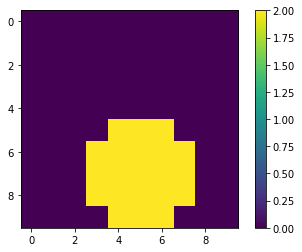

In [39]:
plt.imshow(mask[835:845,380:390])
plt.colorbar()


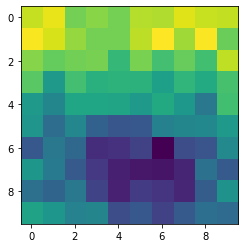

In [40]:
plt.imshow(jpg[835:845,380:390, 1])


In [52]:
for i in range(len(ras)):
    offset_ra, offset_dec = np.random.rand()*5*u.arcmin, np.random.rand()*5*u.arcmin
    ra_cent = ras[i]*u.deg+offset_ra
    dec_cent = decs[i]*u.deg+offset_dec

    ra_min, ra_max = ra_cent - 10*u.arcmin, ra_cent + 10*u.arcmin
    dec_min, dec_max = dec_cent - 10*u.arcmin, dec_cent + 10*u.arcmin

    if ra_max < ra_min:
        ra_min -= 360
    
    box = np.array([[dec_min.value, ra_min.value],[dec_max.value, ra_max.value]]) * utils.degree
    #c1 = SkyCoord(ra_min, dec_min, frame='icrs', unit='deg')
    #c2 = SkyCoord(ra_max, dec_max, frame='icrs', unit='deg')

    #print(dec_min, dec_max)
    #print(c1.ra.hms, c2.ra.hms)
    #print(box)
    #Make jpg of box
    jpg, cur_wcs = make_jpg('/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/', box)
    if type(jpg) == int: continue
    #plt.imshow(jpg[...,0])
    #plt.show()
    #plt.close()
    #im = Image.fromarray(jpg, 'RGB')
    #im.save("/project/r/rbond/jorlo/datasets/ACT_tiles/freq_tiles/{}.jpg".format(key))
    np.savez_compressed("/project/r/rbond/jorlo/datasets/ACT_tiles/indv_freq_tiles/{}".format(str(i).zfill(4)), jpg)
    mask = make_mask(jpg, act_catalog, [[ra_min.value, ra_max.value], [dec_min.value, dec_max.value]], cur_wcs, size = 4.8)
    #print(mask.shape)
    np.savez_compressed("/project/r/rbond/jorlo/datasets/ACT_tiles/indv_masks/{}_mask".format(str(i).zfill(4)), mask)

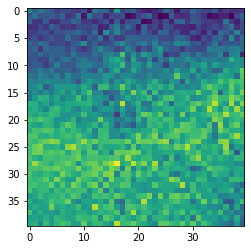

In [50]:
plt.imshow(jpg[...,1])

In [35]:
with np.load("/project/r/rbond/jorlo/datasets/ACT_tiles/masks/{}_mask.npz".format(key)) as data:
        mask_load = data['arr_0']

In [39]:
obj_ids_load = np.unique(np.array(mask_load))

In [40]:
obj_ids_load

array([0., 1., 2., 3., 4., 5., 6.])

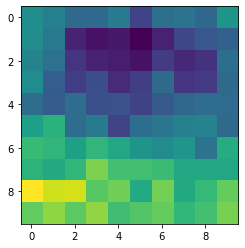

In [60]:
wcs.utils.proj_plane_pixel_scales(cur_wcs)*60

array([0.5, 0.5])

# Cluster Centered Stamps

In [12]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
ras, decs, act_sn = act_catalog[1].data['RADeg'], act_catalog[1].data['decDeg'], act_catalog[1].data['SNR']


In [22]:
size = 2.5

offset = 2.0

to_return_90 = []
randoms_90 = []
map_path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/'

cur_map = enmap.read_map(map_path + 'act_planck_daynight_f{}_map.fits'.format('090'))[0]

offsets = []

for i, name in enumerate(act_catalog[1].data['name']):
    width = 5.0*utils.arcmin
    
    ra_off, dec_off = np.random.rand(2)*offset*u.arcmin
    offsets.append([ra_off, dec_off])
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg 

    ra += offsets[i][0]
    dec += offsets[i][1]
    
    stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    #stamp = normalize_map(stamp)
    to_return_90.append(stamp)
    
    theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
    ra += np.cos(theta)*dr*u.arcmin
    dec += np.sin(theta)*dr*u.arcmin
    
    ra -= offsets[i][0]
    dec -= offsets[i][1]
    
    rand_stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    
    randoms_90.append(rand_stamp)
    
to_return_90 = np.stack(to_return_90, axis=0)
randoms_90 = np.stack(randoms_90, axis=0)

to_return_150 = []
randoms_150 = []

cur_map = enmap.read_map(map_path + 'act_planck_daynight_f{}_map.fits'.format('150'))[0]

for i, name in enumerate(act_catalog[1].data['name']):
    width = 5.0*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    

    ra += offsets[i][0]
    dec += offsets[i][1]
    
    stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    #stamp = normalize_map(stamp)
    to_return_150.append(stamp)
    
    theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
    ra += np.cos(theta)*dr*u.arcmin
    dec += np.sin(theta)*dr*u.arcmin
    
    rand_stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    
    randoms_150.append(rand_stamp)
    
to_return_150 = np.stack(to_return_150, axis=0)
randoms_150 = np.stack(randoms_150, axis=0)

to_return_220 = []
randoms_220 = []

cur_map = enmap.read_map(map_path + 'act_planck_daynight_f{}_map.fits'.format('220'))[0]

for i, name in enumerate(act_catalog[1].data['name']):
    width = 5.0*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    
    
    
    ra += offsets[i][0]
    dec += offsets[i][1]

    stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    #stamp = normalize_map(stamp)
    to_return_220.append(stamp)
    
    theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
    ra += np.cos(theta)*dr*u.arcmin
    dec += np.sin(theta)*dr*u.arcmin
    
    rand_stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    
    randoms_220.append(rand_stamp)
    
to_return_220 = np.stack(to_return_220, axis=0)
randoms_220 = np.stack(randoms_220, axis=0)

In [23]:
to_return = np.stack([to_return_90, to_return_150, to_return_220], axis = -1)
randoms = np.stack([randoms_90, randoms_150, randoms_220], axis = -1)

In [24]:
to_return.shape

(4195, 41, 41, 3)

In [25]:
randoms.shape

(4195, 41, 41, 3)

In [26]:
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_freq_stamps/all_clusters_offset.npz', to_return)
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_freq_stamps/randoms.npz', randoms)

In [27]:
offsets

[[<Quantity 1.77377797 arcmin>, <Quantity 1.31512559 arcmin>],
 [<Quantity 1.42211724 arcmin>, <Quantity 1.85129277 arcmin>],
 [<Quantity 0.92705887 arcmin>, <Quantity 1.0624802 arcmin>],
 [<Quantity 0.8689888 arcmin>, <Quantity 0.20484821 arcmin>],
 [<Quantity 1.98746077 arcmin>, <Quantity 1.77077256 arcmin>],
 [<Quantity 1.41275386 arcmin>, <Quantity 0.69555906 arcmin>],
 [<Quantity 0.52207623 arcmin>, <Quantity 0.17776005 arcmin>],
 [<Quantity 1.60976142 arcmin>, <Quantity 1.73016798 arcmin>],
 [<Quantity 1.52529009 arcmin>, <Quantity 0.64914156 arcmin>],
 [<Quantity 1.66635367 arcmin>, <Quantity 0.85762957 arcmin>],
 [<Quantity 1.51165244 arcmin>, <Quantity 1.27269585 arcmin>],
 [<Quantity 1.31106619 arcmin>, <Quantity 1.2679472 arcmin>],
 [<Quantity 0.46878351 arcmin>, <Quantity 0.16954994 arcmin>],
 [<Quantity 0.71286321 arcmin>, <Quantity 0.51696604 arcmin>],
 [<Quantity 1.81504139 arcmin>, <Quantity 1.08281158 arcmin>],
 [<Quantity 1.2960502 arcmin>, <Quantity 1.99854195 arcmin

In [26]:
stack = 0
n = 0

for i in range(to_return.shape[0]):
    weight = act_sn[i]
    stack += to_return[i,...,0]*weight
    n += weight

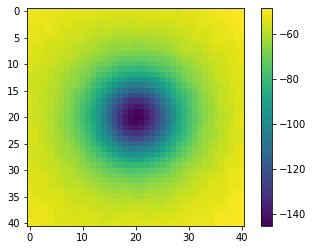

In [27]:
plt.imshow(stack/n)
plt.colorbar()
plt.show()
plt.close()

# Single Cluster y stamps

In [5]:
path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'

ymap = enmap.read_map(path + 'stitched_Arnaud_M2e14_z0p4_filteredMap.fits')

In [6]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
ras, decs = act_catalog[1].data['RADeg'], act_catalog[1].data['decDeg']

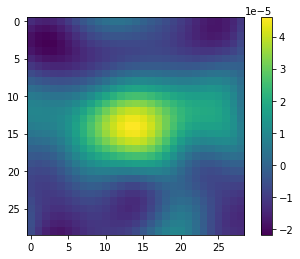

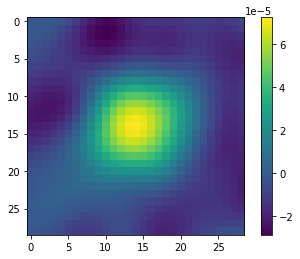

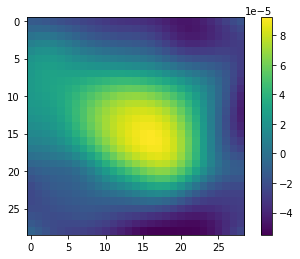

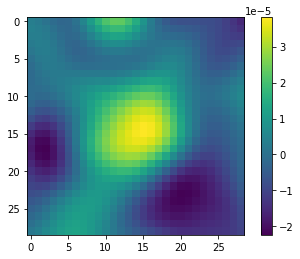

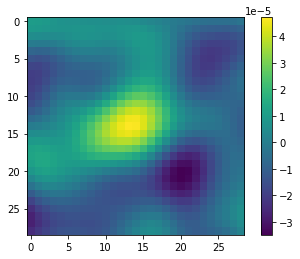

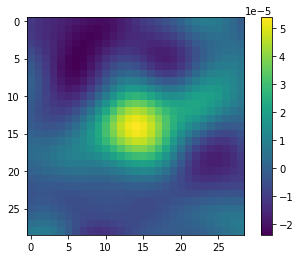

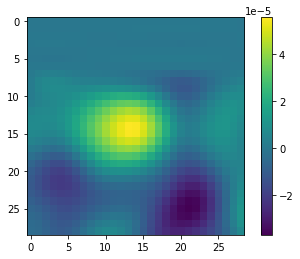

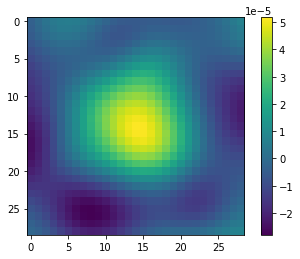

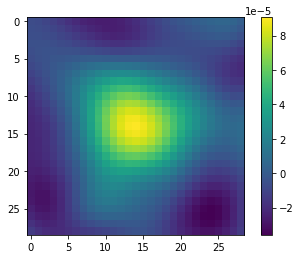

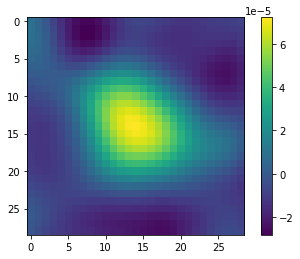

In [13]:
to_return_y = []

for i in range(10):
    width = 3.5*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    

    stamp = reproject.thumbnails(ymap, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    #stamp = normalize_map(stamp)
    plt.imshow(stamp)
    plt.colorbar()
    plt.show()
    plt.close()
    #stamp = normalize_map(stamp)

    to_return_y.append(stamp)
to_return_y = np.stack(to_return_y, axis=0)
to_return_y/= np.amax(to_return_y)
pk.dump(to_return_y, open('/project/r/rbond/jorlo/datasets/act_y_stamps/test_clusters.pk', 'wb'))

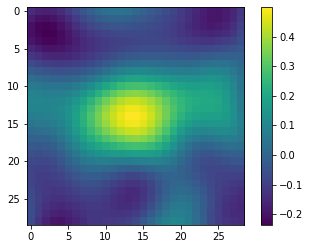

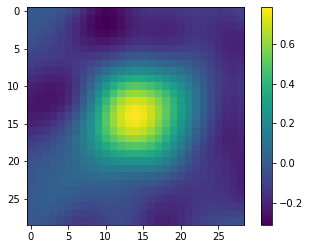

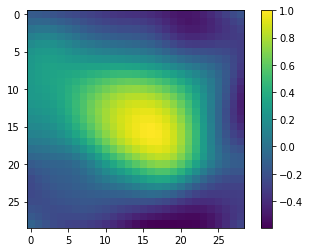

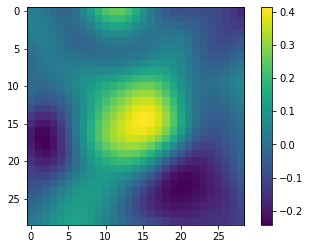

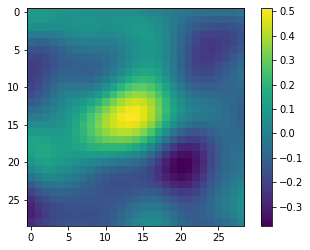

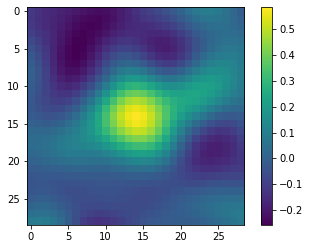

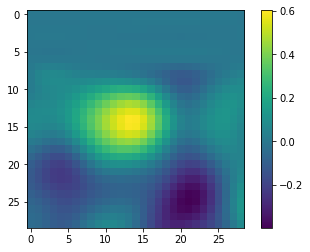

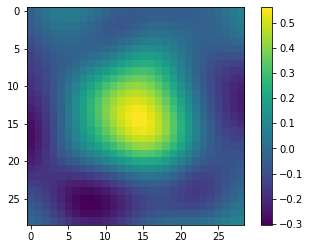

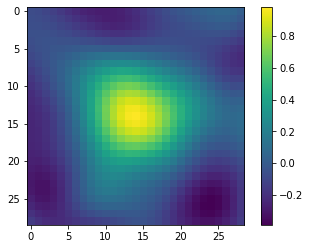

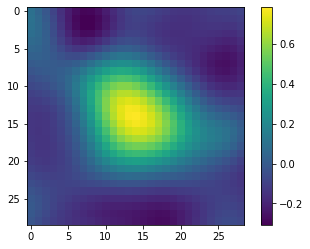

In [14]:
for i in range(10):
    plt.imshow(to_return_y[i,...])
    plt.colorbar()
    plt.show()
    plt.close()

In [24]:
to_return_y = []

for i, name in enumerate(act_catalog[1].data['name']):
    width = 4.5*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    

    stamp = reproject.thumbnails(ymap, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    #stamp = normalize_map(stamp)
    to_return_y.append(stamp)

to_return_y = np.stack(to_return_y, axis=0)

In [25]:
to_return_y/= np.amax(to_return_y)

In [26]:
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_y_stamps/all_clusters.npz', to_return_y)

# ILC Compton-y

In [44]:
path = '/project/r/rbond/msyriac/ilc_dr6v3/20220224/'

ymap = enmap.read_map(path + 'ilc_SZ_yy.fits')
mask = enmap.read_map(path + 'wide_mask_GAL080_apod_3.00_deg.fits')

In [45]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
ras, decs = act_catalog[1].data['RADeg'], act_catalog[1].data['decDeg']

In [46]:
to_return_y = []

for i , name in enumerate(act_catalog[1].data['name']):
    width = 4.5*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg    
    mask_stamp = reproject.thumbnails(mask, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    
    if np.any(mask_stamp < 1): continue
    
    stamp = reproject.thumbnails(ymap, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
   
    to_return_y.append(stamp)

to_return_y = np.stack(to_return_y, axis=0)

In [47]:
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_y_stamps/ilc_all_clusters.npz', to_return_y)

## ILC Randoms

In [48]:
path = '/project/r/rbond/msyriac/ilc_dr6v3/20220224/'

ymap = enmap.read_map(path + 'ilc_SZ_yy.fits')
mask = enmap.read_map(path + 'wide_mask_GAL080_apod_3.00_deg.fits')

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
ras, decs = act_catalog[1].data['RADeg'], act_catalog[1].data['decDeg']

In [66]:
to_return_randoms = []

i = 0 

for i in range(len(ras)):
    width = 4.5*utils.arcmin
    
    ra, dec = ras[i]*u.deg, decs[i]*u.deg
    
    
    theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
    ra += np.cos(theta)*dr*u.arcmin
    dec += np.sin(theta)*dr*u.arcmin
    
    mask_stamp = reproject.thumbnails(mask, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
    if mask_stamp.at([0,0])< 0.99: continue
    '''
    while np.any(mask_stamp < 0.9):
        if mask_stamp.at([0,0])< 0.8: break
        ra, dec = ras[i]*u.deg, decs[i]*u.deg
    
        theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
        ra += np.cos(theta)*dr*u.arcmin
        dec += np.sin(theta)*dr*u.arcmin

        mask_stamp = reproject.thumbnails(mask, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                            apod = 2*utils.arcmin)
    '''
    stamp = reproject.thumbnails(ymap, ( dec.to(u.radian).value,ra.to(u.radian).value), r=width,
                        apod = 2*utils.arcmin)
   
    to_return_randoms.append(stamp)

to_return_randoms = np.stack(to_return_randoms, axis=0)


In [67]:
np.savez_compressed('/project/r/rbond/jorlo/datasets/act_y_stamps/ilc_randoms.npz', to_return_randoms)

In [68]:
to_return_randoms.shape

(3875, 37, 37)

In [69]:
to_return_y.shape

(3474, 37, 37)

In [5]:
#Paths to a couple coadded maps

#path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'
path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/'
#path = '/project/r/rbond/jorlo/stitched_Beam_filteredMap.fits'
freqs = ['220', '150', '090']

#Unused code for taking a look at the maps
#cur_map = enmap.read_map(path + 'act_planck_s08_s19_cmb_f{}_night_map.fits'.format(freqs[2]))
cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[2]))

cur_map = cur_map[0]

#plots = enplot.plot(cur_map,range=300,mask=0)
#enplot.write("plots_example",plots)

#def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs))
#enplot.show(enplot.plot(cur_map))

In [6]:
cur_map.wcs

In [11]:
from astropy.utils.data import get_pkg_data_filename

wcs = cur_map.wcs

plt.subplot(projection=wcs)
plt.imshow(cur_map, vmin=-300, vmax=300)#, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

In [11]:
hdu.header

In [12]:
plt.imshow(cur_map[0], vmin = -300, vmax = 300)

In [26]:

#Create a box
ra_min = 0; ra_max = 10; dec_min=0; dec_max=10
box = np.array([[dec_min,ra_min],[dec_max,ra_max]]) * utils.degree
box = [[-1.0645054,   0.94960714], [-0.93651459,  1.25052841]]
print(box)
#Make jpg of box
jpg = make_jpg('/home/r/rbond/sigurdkn/project/actpol/map_coadd/20211219/release/', box)

#The image package allows us to turn the array into a jpg for saving
im = Image.fromarray(jpg, 'RGB')
im.save("test_jpg.jpeg")

In [27]:
cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[2]), box = box)

cur_map = cur_map[0]

from astropy.utils.data import get_pkg_data_filename

wcs = cur_map.wcs

plt.subplot(projection=wcs)
plt.imshow(cur_map, vmin=-300, vmax=300)#, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

In [25]:
jpg.shape

In [14]:
plt.imshow(jpg[...,2])
plt.colorbar()

In [15]:
np.amax(jpg[...,2])

In [11]:
for i in range(0, 360, 10):
    ra_min = i; ra_max = i+10
    dec_min = 0; dec_max = 10
    #TODO: Galaxy masking
    box = np.array([[dec_min,ra_min],[dec_max,ra_max]]) * utils.degree
    cur_map = enmap.read_map(path + 'act_planck_daynight_f{}_map.fits'.format(freqs[2]), box=box)
    plt.imshow(cur_map[0], vmin=-300, vmax = 300)
    plt.show()
    plt.close()

In [6]:
plt.imshow(cur_map[0], vmin=-300, vmax = 300)

In [12]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

actRa = act_catalog[1].data['RADeg']
actNames = act_catalog[1].data['name']
actDec = act_catalog[1].data['decDeg']
actRa, actDec = np.array(actRa), np.array(actDec)
actSnr = act_catalog[1].data['fixed_SNR']
actz = act_catalog[1].data['redshift']

In [13]:
#path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'

#tileName = tileFinder(actRa[0], actDec[0], s18d)
#tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
ra, dec = actRa[0]*u.deg, actDec[0]*u.deg
stamp = reproject.thumbnails(cur_map, ( dec.to(u.radian).value,ra.to(u.radian).value), r=5*utils.arcmin,
                            apod = 2*utils.arcmin)#5.*np.pi/(60*180))
#plot = enplot.plot(stamp)
#enplot.show(plot)

In [17]:
plt.imshow(stamp[0])
print(stamp.shape)
plt.colorbar()

In [31]:
print(min(np.abs(stamp.wcs.wcs.cdelt))*utils.degree/2)
print(min(np.abs(stamp.wcs.wcs.cdelt))*utils.degree/2*(3600 * 180)/np.pi)
print(0.004167*(60 * 180)/np.pi)

In [32]:
print(10/41*60)

In [33]:
print(cur_map.wcs.wcs.cdelt)
print(stamp.wcs.wcs.cdelt)

In [34]:
ra, dec = actRa[0], actDec[0]
stamp1 = freq_cutout(ra, dec, cur_map, scale = 399, width = 5*utils.arcmin)
plt.imshow(stamp1)
print(stamp.shape)

In [ ]:
stamp2 = freq_cutout(ra, dec, cur_map, scale = 399, width = 5*utils.arcmin)
plt.imshow(stamp2)
print(stamp.shape)

In [ ]:
plt.imshow((stamp1-stamp2)/stamp1)
plt.colorbar()



In [ ]:
stamp = 0
for i in range(len(actRa)):
    ra, dec = actRa[i]*u.deg, actDec[i]*u.deg
    full_box  = reproject.thumbnails(cur_map, (dec.to(u.radian).value, ra.to(u.radian).value), r=20.*np.pi/(60*180))
    stamp+=full_box

In [ ]:
plt.imshow(stamp)

In [ ]:
path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'

freq_map_090 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f090_night_map.fits')
freq_map_150 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f150_night_map.fits')
freq_map_220 = enmap.read_map(path + 'act_planck_s08_s19_cmb_f220_night_map.fits')

temp = cutout(actRa[:2], actDec[:2], freq_map_090, freq_map_150, freq_map_220, scale = 10)

# WISE Stamping

In [3]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

ras, decs, zs = np.array(act_catalog[1].data['RADeg']), np.array(act_catalog[1].data['decDeg']), np.array(act_catalog[1].data['redshift'])

c = SkyCoord(ras[500], decs[500], unit="deg")
paths = SkyView.get_images(position=c,
                           survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'],
                          radius = 5*u.arcmin)

In [ ]:
z_cut = 0.

for i in range(len(ras)):
    print(i, end = '\r')
    if zs[i] < z_cut: continue
    if os.path.exists('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/cluster_{}.npz'.format(str(i).zfill(4))):
        continue
    try:
        c = SkyCoord(ras[i], decs[i], unit="deg")
        paths = SkyView.get_images(position=c,
                           survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'],
                          radius = 5*u.arcmin)
    except: continue
    
    to_return = np.zeros([300, 300, 4])
    
    for j in range(4):
        to_return[...,j] = paths[j][0].data
        
    np.savez_compressed('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/cluster_{}.npz'.format(str(i).zfill(4)), to_return)
    
    mask = make_mask_wise(paths[0][0].data, [150, 150], radius*2/300, size = 4.8)

    #print(mask.shape)
    np.savez_compressed("/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/masks/{}_mask".format(str(i).zfill(4)), mask)

In [ ]:
for i in range(len(ras)):
    print(i, end = '\r')
    if os.path.exists('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/randoms_{}.npz'.format(str(i).zfill(4))):
        continue
        
    theta, dr = np.random.uniform(0, 2*np.pi), np.random.uniform(5,10)
    ra, dec = ras[i]*u.deg+np.cos(theta)*dr*u.arcmin, decs[i]*u.deg+np.sin(theta)*dr*u.arcmin
    c = SkyCoord(ra, dec)

    try:
        paths = SkyView.get_images(position=c,
                           survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'],
                          radius = 7*u.arcmin)
    except: continue
    
    to_return = np.zeros([300, 300, 4])
    
    for j in range(4):
        to_return[...,j] = paths[j][0].data
        
    np.savez_compressed('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/randoms_{}.npz'.format(str(i).zfill(4)), to_return)

In [32]:
z_cut = 0.
radius = 7

for i in range(len(ras)):
    print(i, end = '\r')
    if zs[i] < z_cut: continue
    if os.path.exists('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/cluster_{}.npz'.format(str(i).zfill(4))):
        continue
    try:
    offset_ra, offset_dec = np.random.rand()*2.5/60, np.random.rand()*2.5/60


    c = SkyCoord(ras[i]+offset_ra, decs[i]+offset_dec, unit="deg")
    paths = SkyView.get_images(position=c,
                               survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'],
                              radius = radius*u.arcmin)
    
    except: continue
    
    to_return = np.zeros([300, 300, 4])
    
    for j in range(4):
        to_return[...,j] = paths[j][0].data
        
    np.savez_compressed('/project/r/rbond/jorlo/datasets/act_offset_wise_stamps/cluster_{}.npz'.format(str(i).zfill(4)), to_return)
    mask = make_mask_wise(paths[0][0].data, [150+(offset_ra*60/(2*radius)*300), 150+(offset_dec*60/(2*radius)*300)], radius*2/300, size = 4.8)
    np.savez_compressed("/project/r/rbond/jorlo/datasets/act_offset_wise_stamps/masks/{}_mask".format(str(i).zfill(4)), mask)

-0.016666666666666666


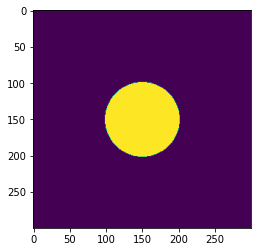

In [44]:
plt.imshow(mask)

In [43]:
c = SkyCoord(ras[500], decs[500], unit="deg")
paths = SkyView.get_images(position=c,
                           survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'],
                          radius = radius*u.arcmin)

mask = make_mask_wise(paths[0][0].data, [150, 150], radius*2/300, size = 4.8)
np.savez_compressed("/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/masks/cluster_mask_{}".format(str(i).zfill(4)), mask)

In [45]:
for i, dirname in enumerate(os.listdir('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/')):
    if dirname[0] == 'c':
        np.savez_compressed("/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/masks/cluster_mask_{}".format(dirname[8:12]), mask)
